In [1]:
#  Copyright 2023 Google LLC
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      https://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.

# Hubbard Model

Gates for Qubitizing the Hubbard Model.

This follows section V. of the [Linear T Paper](https://arxiv.org/abs/1805.03662).

The Hubbard model is a special case of the electronic structure Hamiltonian
restricted to spins on a planar grid.

$$
H = -t \sum_{\langle p,q \rangle, \sigma} a_{p,\sigma}^\dagger a_{q,\sigma}
    + \frac{u}{2} \sum_{p,\alpha\ne\beta} n_{p, \alpha} n_{p, \beta}
$$

Under the Jordan-Wigner transformation this is

$$
\def\Zvec{\overrightarrow{Z}}
\def\hop#1{#1_{p,\sigma} \Zvec #1_{q,\sigma}}
H = -\frac{t}{2} \sum_{\langle p,q \rangle, \sigma} (\hop{X} + \hop{Y})
  + \frac{u}{8} \sum_{p,\alpha\ne\beta} Z_{p,\alpha}Z_{p,\beta}
  - \frac{u}{4} \sum_{p,\sigma} Z_{p,\sigma} + \frac{uN}{4}\mathbb{1}
$$


This model consists of a PREPARE and SELECT operation where our selection operation has indices
for $p$, $\alpha$, $q$, and $\beta$ as well as two indicator bits $U$ and $V$. There are four cases
considered in both the PREPARE and SELECT operations corresponding to the terms in the Hamiltonian:

 - $U=1$, single-body Z
 - $V=1$, spin-spin ZZ term
 - $p<q$, XZX term
 - $p>q$, YZY term.

See the documentation for `PrepareHubbard` and `SelectHubbard` for details.

In [2]:
import cirq
import numpy as np
import qualtran.cirq_interop.testing as cq_testing
from qualtran.cirq_interop.jupyter_tools import display_gate_and_compilation
from qualtran.cirq_interop.t_complexity_protocol import t_complexity
from typing import *

## `SelectHubbard`
The SELECT operation optimized for the 2D Hubbard model.

In contrast to the arbitrary chemistry Hamiltonian, we:
 - explicitly consider the two dimensions of indices to permit optimization of the circuits.
 - dispense with the `theta` parameter.

If neither $U$ nor $V$ is set we apply the kinetic terms of the Hamiltonian:

$$
-\hop{X} \quad p < q \\
-\hop{Y} \quad p > q
$$

If $U$ is set we know $(p,\alpha)=(q,\beta)$ and apply the single-body term: $-Z_{p,\alpha}$.
If $V$ is set we know $p=q, \alpha=0$, and $\beta=1$ and apply the spin term:
$Z_{p,\alpha}Z_{p,\beta}$

The circuit for implementing $\textit{C-SELECT}_{Hubbard}$ has a T-cost of $10 * N + log(N)$
and $0$ rotations.

#### Parameters
- `x_dim`: the number of sites along the x axis.
- `y_dim`: the number of sites along the y axis.
- `control_val`: Optional bit specifying the control value for constructing a controlled
    version of this gate. Defaults to None, which means no control.


#### Registers
 - `control`: A control bit for the entire gate.
 - `U`: Whether we're applying the single-site part of the potential.
 - `V`: Whether we're applying the pairwise part of the potential.
 - `p_x`: First set of site indices, x component.
 - `p_y`: First set of site indices, y component.
 - `alpha`: First set of sites' spin indicator.
 - `q_x`: Second set of site indices, x component.
 - `q_y`: Second set of site indices, y component.
 - `beta`: Second set of sites' spin indicator.
 - `target`: The system register to apply the select operation.

#### References
Section V. and Fig. 19 of https://arxiv.org/abs/1805.03662.


In [3]:
from qualtran.bloqs.hubbard_model import SelectHubbard, PrepareHubbard

x_dim, y_dim, t = 4, 4, 5
mu = 4 * t

select = cq_testing.GateHelper(
    SelectHubbard(x_dim=x_dim, y_dim=y_dim, control_val=1)
)
display_gate_and_compilation(select, include_costs=True)

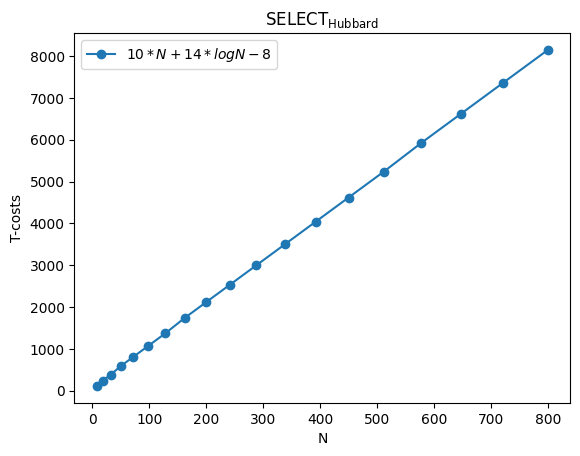

In [4]:
import matplotlib.pyplot as plt

x, y = [], []
for dim in range(2, 21):
    select = SelectHubbard(x_dim=dim, y_dim=dim, control_val=1)
    cost = t_complexity(select)
    N = 2 * dim * dim
    logN = (2 * (dim - 1).bit_length() + 1)
    # 2 * (4 * (N - 1)) : From 2 SelectMajoranaFermion gates.
    # 4 * (N/2) : From 1 mulit-controlled ApplyToLthQubit gate on N / 2 targets.
    # 2 * 7 * logN : From 2 CSWAPS on logN qubits corresponding to (p, q) select signature.
    assert cost.t == 10 * N + 14 * logN - 8
    assert cost.rotations == 0
    x.append(N)
    y.append(cost.t)
    
plt.xlabel('N')
plt.ylabel('T-costs')
plt.title('$\mathrm{SELECT}_\mathrm{Hubbard}$')
plt.plot(x, y, label='$10 * N + 14 * logN - 8$', marker="o")
plt.legend()
plt.show()

## `PrepareHubbard`
The PREPARE operation optimized for the 2D Hubbard model.

In contrast to the arbitrary chemistry Hamiltonian, we:
 - explicitly consider the two dimensions of indices to permit optimization of the circuits.
 - dispense with the `theta` parameter.

The circuit for implementing $\textit{PREPARE}_{Hubbard}$ has a T-cost of $O(log(N)$ and uses $O(1)$
single qubit rotations.


#### Parameters
- `x_dim`: the number of sites along the x axis.
- `y_dim`: the number of sites along the y axis.
- `t`: coefficient for hopping terms in the Hubbard model hamiltonian.
- `mu`: coefficient for single body Z term and two-body ZZ terms in the Hubbard model hamiltonian.

#### Registers
 - `control`: A control bit for the entire gate.
 - `U`: Whether we're applying the single-site part of the potential.
 - `V`: Whether we're applying the pairwise part of the potential.
 - `p_x`: First set of site indices, x component.
 - `p_y`: First set of site indices, y component.
 - `alpha`: First set of sites' spin indicator.
 - `q_x`: Second set of site indices, x component.
 - `q_y`: Second set of site indices, y component.
 - `beta`: Second set of sites' spin indicator.
 - `target`: The system register to apply the select operation.
 - `junk`: Temporary Work space.

#### References
Section V. and Fig. 20 of https://arxiv.org/abs/1805.03662.

In [5]:
prepare = cq_testing.GateHelper(
    PrepareHubbard(x_dim=x_dim, y_dim=y_dim, t=t, mu=mu)
)
display_gate_and_compilation(prepare, include_costs=True)

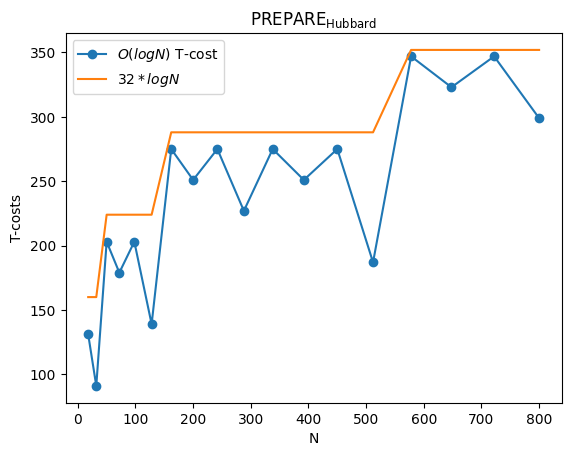

In [6]:
import matplotlib.pyplot as plt

x, y_t, y_max = [], [], []
for dim in range(3, 21):
    prepare = PrepareHubbard(x_dim=dim, y_dim=dim, t=t, mu=mu)
    cost = t_complexity(prepare)
    N = 2 * dim * dim
    logN = 2 * (dim - 1).bit_length() + 1
    assert cost.t <= 32 * logN
    assert cost.rotations <= 2 * logN + 9
    x.append(N)
    y_t.append(cost.t)
    y_max.append(32 * logN)
    
plt.xlabel('N')
plt.ylabel('T-costs')
plt.title('$\mathrm{PREPARE}_\mathrm{Hubbard}$')
plt.plot(x, y_t, label='$O(logN)$ T-cost', marker="o")
plt.plot(x, y_max, label='$32 * logN$')
plt.legend()
plt.show()